In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [2]:
ds = tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCCFPDV/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteCCFPDV/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
dataiterator = ds.as_numpy_iterator()
dataiterator.next()['image']

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

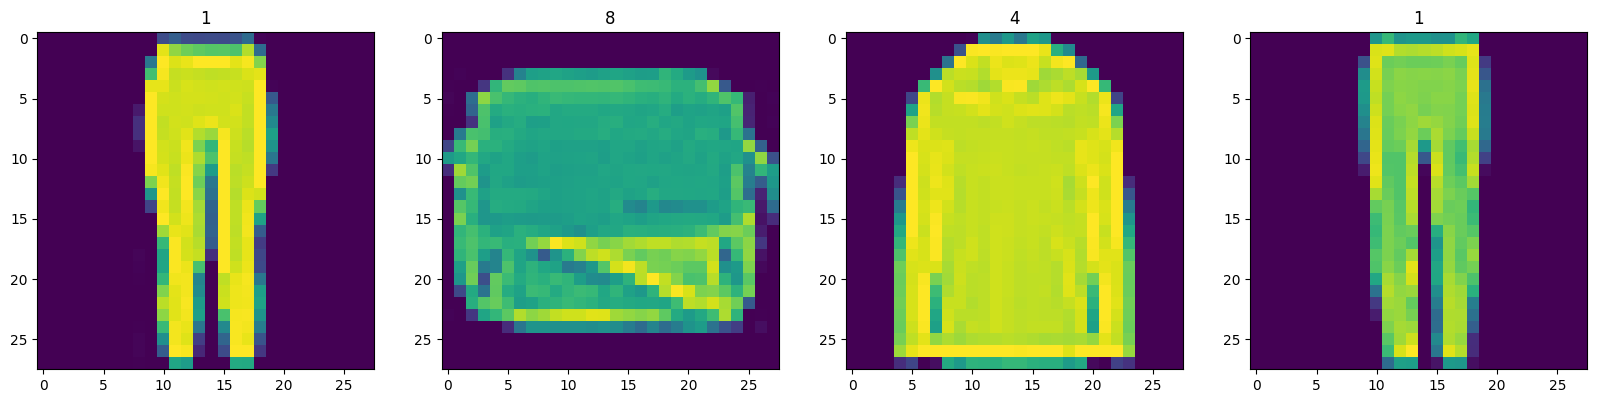

In [4]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample = dataiterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

In [5]:
def scale_images(data): 
    image = data['image']
    return image / 255

In [6]:
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images) 
ds = ds.cache()
ds = ds.shuffle(60000)
ds = ds.batch(128)
ds = ds.prefetch(64)

In [7]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [8]:
def build_generator(): 
    model = Sequential()

    model.add(Dense(7*7*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7,7,128)))

    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
 
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    
    return model

In [9]:
generator = build_generator()

In [10]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [11]:
def build_discriminator(): 
    model = Sequential()

    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [12]:
discriminator = build_discriminator()

In [13]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [14]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [15]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        with tf.GradientTape() as g_tape: 
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            predicted_labels = self.discriminator(gen_images, training=False)

            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [16]:
fashgan = FashionGAN(generator, discriminator)

In [17]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [18]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/MyDrive/Colab Notebooks/images', f'generated_img_{epoch}_{i}.png'))

In [19]:
hist = fashgan.fit(ds, epochs=50, callbacks=[ModelMonitor()])

Epoch 1/50
  6/469 [..............................] - ETA: 1:20 - d_loss: 0.6945 - g_loss: 0.6757

469/469 [==============================] - 102s 178ms/step - d_loss: 0.5349 - g_loss: 0.8669
Epoch 2/50
469/469 [==============================] - 83s 178ms/step - d_loss: 0.5936 - g_loss: 1.9205
Epoch 3/50
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6785 - g_loss: 0.7069
Epoch 4/50
469/469 [==============================] - 83s 176ms/step - d_loss: 0.6927 - g_loss: 0.5604
Epoch 5/50
469/469 [==============================] - 83s 176ms/step - d_loss: 0.6550 - g_loss: 0.6209
Epoch 6/50
469/469 [==============================] - 83s 176ms/step - d_loss: 0.6998 - g_loss: 0.5293
Epoch 7/50
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6891 - g_loss: 0.6065
Epoch 8/50
469/469 [==============================] - 83s 176ms/step - d_loss: 0.6899 - g_loss: 0.6201
Epoch 9/50
469/469 [==============================] - 83s 177ms/step - d_loss: 0.6981 - g_loss: 0.6260
Epoch 10/50
469/469 [==============================] - 83s 176ms/step - d_loss: 0.6

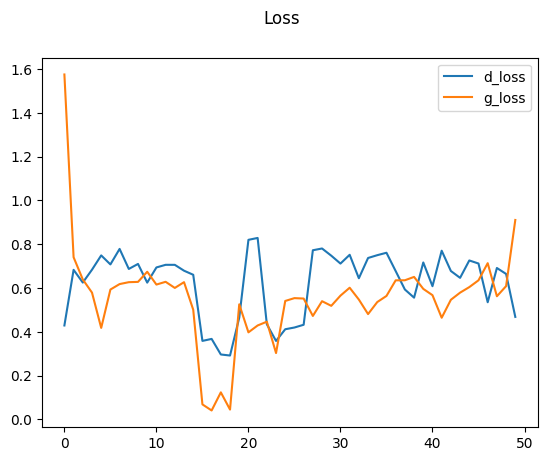

In [20]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [21]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 0s 449ms/step


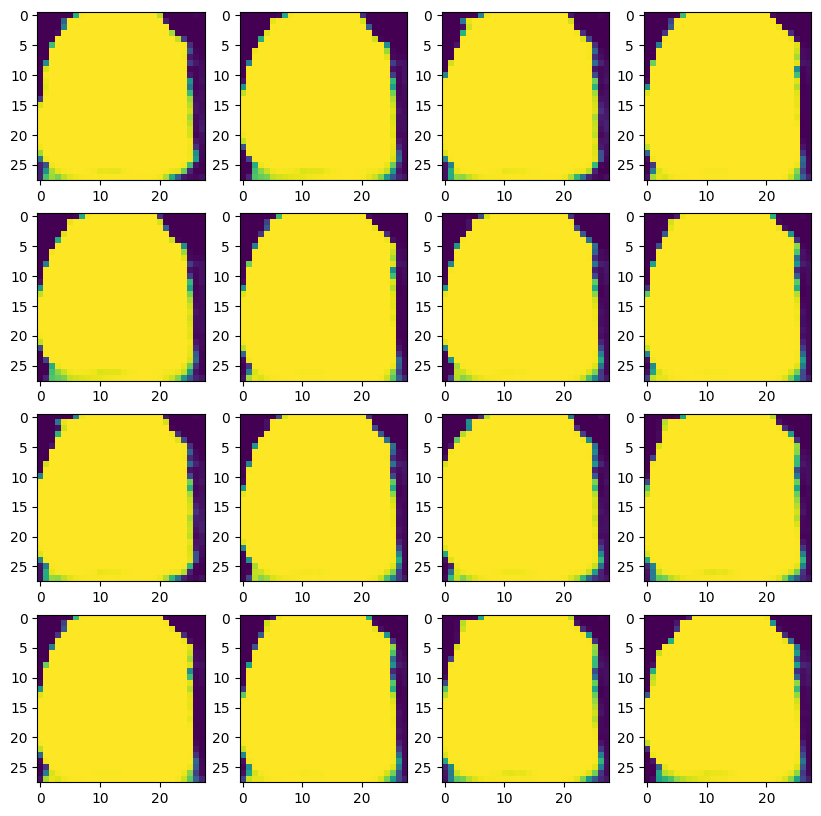

In [22]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

In [23]:
generator.save('generator.h5')